In [26]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import functools as ft
from itertools import chain

import tensorflow as tf
import keras as k

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Activation
from keras.models import Model, Sequential, load_model
from keras.layers.recurrent import LSTM
from keras.initializers import Constant

from gensim.models.word2vec import Word2Vec
from gensim.models import FastText, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from livelossplot import PlotLossesKeras

import requests
from pprint import pprint


# Bootstrap Corpus

In [25]:
google_model = KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)

# Load Behaviors from NSV

In [3]:
doc_complete = pd.read_csv('../Data/behavior.csv')
doc_complete = list(doc_complete.iloc[:,1])

doc = [d.split(' ') for d in doc_complete]

doc

[['', 'chinese', 'fire', 'drill', ''],
 ['abusive', 'cycle'],
 ['action', 'assembly', 'theory'],
 ['active'],
 ['adoption'],
 ['age', '17', '19'],
 ['aggresion', 'towards', 'objects'],
 ['aggressive'],
 ['alcohol', 'use'],
 ['alienation'],
 ['alloplastic', 'adaptation'],
 ['always', 'and', '', 'never', '', 'statements'],
 ['ambitious'],
 ['anger'],
 ['animal', 'abuse'],
 ['animal', 'spirits'],
 ['argumentative'],
 ['asccismus'],
 ['assault', 'with', 'gun'],
 ['assault', 'with', 'knife'],
 ['assertive'],
 ['attention', 'deficit', 'hyperactivity', 'disorder'],
 ['attention', 'seeking'],
 ['attitude', 'change'],
 ['autoplastic', 'defense', 'mechanism'],
 ['avoidance'],
 ['avoidance', 'coping'],
 ['bad', 'coping'],
 ['bad', 'habit'],
 ['baiting'],
 ['beat'],
 ['beat', 'up'],
 ['behavior'],
 ['behavior', 'change'],
 ['behavioral', 'confirmation'],
 ['behavioral', 'contagion'],
 ['behavioral', 'modernity'],
 ['behavioral', 'urbanism'],
 ['belittle', 'partner'],
 ['belittling', '', 'condescen

# Remove stop words, Lemmatize

In [4]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [5]:
def clean_lemmatize(doc):
    """lemmatize and clean doc"""
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Run word_list into an input volume
def clean(word_list):
    lemmatized_list = []
    for word in word_list:
        #assert type(word) == list
        if type(word) == list:
            temp = [clean_lemmatize(x) for x in word]
            lemmatized_list.append(temp)
    for i in range(len(lemmatized_list)):
        temp = [x for x in lemmatized_list[i] if x!= '' and x.isalpha()]
        lemmatized_list[i] = temp
        
    return lemmatized_list

In [6]:
clean_words = clean(doc)

# Create Word2Vec, FastText models

In [7]:
w2v_model = Word2Vec(clean_words, size=300, window=5, min_count=5, iter=100, workers=-1)
ft_model = FastText(clean_words, size=300, window=5, min_count=5, iter=100, workers=-1)

In [8]:
w2v = {w: vec for w, vec in zip(w2v_model.wv.index2word, w2v_model.wv.syn0)}
ftm = {w: vec for w, vec in zip(ft_model.wv.index2word, ft_model.wv.syn0)}

w2v_google = {w: vec for w, vec in zip(w2v_model.wv.index2word, google_model.wv.syn0)}

In [9]:
w2v['violence'].shape, ftm['violence'].shape, w2v_google['violence'].shape

((300,), (300,), (300,))

In [10]:
w2v_google['violence'][:30]

array([ 0.08496094, -0.09521484,  0.11914062,  0.11181641, -0.11132812,
        0.04980469,  0.11425781, -0.09863281,  0.09960938, -0.04150391,
        0.01287842, -0.18164062, -0.11621094,  0.02380371, -0.1640625 ,
        0.12695312,  0.12060547,  0.00946045,  0.04150391, -0.09521484,
       -0.12988281, -0.11523438,  0.07519531, -0.04980469,  0.06591797,
       -0.02905273, -0.08984375,  0.08447266, -0.04785156, -0.02709961],
      dtype=float32)

# Similar words

In [13]:
def similarWords(word_list, model):
    pretrained_weights = model.wv.syn0
    vocab_size, emdedding_size = pretrained_weights.shape
    print('Result embedding shape:', pretrained_weights.shape)
    print('Checking similar words:')
    for word in word_list:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist)
                                 for similar, dist in model.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

In [14]:
similarWords(['violence'], google_model)
similarWords(['violence'], w2v_model)

Result embedding shape: (3000000, 300)
Checking similar words:
  violence -> Violence (0.74), bloodshed (0.71), sectarian_violence (0.65), vio_lence (0.63), violent (0.62), violance (0.61), voilence (0.60), lawlessness (0.58)
Result embedding shape: (14, 300)
Checking similar words:
  violence -> poor (0.11), abuse (0.10), disorder (0.04), behavior (0.04), sexual (0.03), use (0.03), force (0.02), change (0.01)


# Topic Modeling with Cognitive Services

In [15]:
subscription_key = '411aeb319831426bba5cfa04a862b6a0'
text_analytics_base_url = "https://westus2.api.cognitive.microsoft.com/text/analytics/v2.0"
key_phrase_api_url = text_analytics_base_url + "/keyPhrases"
print(key_phrase_api_url)
documents = {'documents' : [
  {'id': '1', 'language': 'en', 'text': 'I had a wonderful experience! The rooms were wonderful and the staff was helpful.'},
  {'id': '2', 'language': 'en', 'text': 'I had a terrible time at the hotel. The staff was rude and the food was awful.'},  
]}
headers   = {'Ocp-Apim-Subscription-Key': subscription_key}
response  = requests.post(key_phrase_api_url, headers=headers, json=documents)
key_phrases = response.json()
pprint(key_phrases)

https://westus2.api.cognitive.microsoft.com/text/analytics/v2.0/keyPhrases
{'documents': [{'id': '1',
                'keyPhrases': ['wonderful experience', 'staff', 'rooms']},
               {'id': '2',
                'keyPhrases': ['food', 'terrible time', 'hotel', 'staff']}],
 'errors': []}


# Classification

In [16]:
# set parameters and load data
epochs = 100
batch_size = 10
time_steps = 6
features = 300

features_path = 'input_vol.npy'
labels_path = 'input_label.npy'

X = np.load(features_path)
Y = np.load(labels_path)
print(X.shape)
print(Y.shape)

(370, 6, 300)
(370, 4)


In [17]:
# randomly shuffle data
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

In [18]:
# split data into train and test sets
train_X = X[0:296,:,:]
test_X = X[297:369,:,:]

train_Y = Y[0:296,:]
test_Y = Y[297:369,:]

In [19]:
# build LSTM layers and train model
model = Sequential()
model.add(LSTM(100, dropout= 0.2, input_shape=(time_steps, features)))
model.add(Activation('relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 160,804
Trainable params: 160,804
Non-trainable params: 0
_________________________________________________________________
None


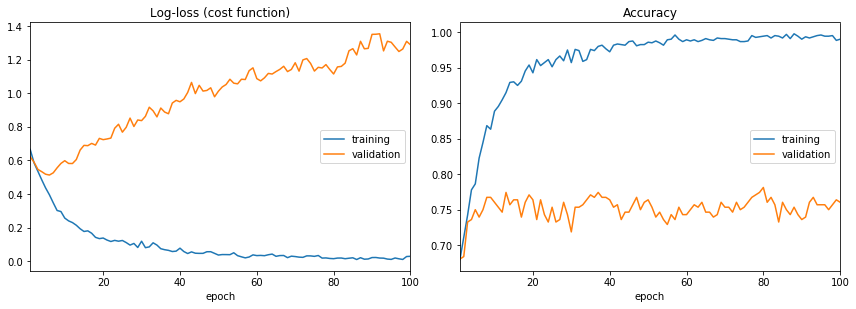

In [20]:
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=epochs, batch_size=batch_size, callbacks=[PlotLossesKeras()])

In [21]:
# load model & data/shuffle it was generated with:
model = load_model('model.h5')
train_X = np.load('train_X.npy')
train_Y = np.load('train_Y.npy')
test_X = np.load('test_X.npy')
test_Y = np.load('test_Y.npy')

In [22]:
# score model and log accuracy
scores = model.evaluate(test_X, test_Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 73.96%


In [23]:
# get predictions
y_pred = model.predict(test_X)
y_pred[:30]

array([[9.71438348e-01, 2.12540937e-04, 1.37556531e-03, 3.06578761e-04],
       [1.24091851e-02, 9.98596847e-01, 3.12259376e-01, 1.27248539e-04],
       [6.20451348e-04, 3.22170346e-03, 9.41281140e-01, 9.98198926e-01],
       [1.15530530e-03, 2.68097175e-03, 3.09408666e-03, 9.99265134e-01],
       [9.97535229e-01, 1.02909096e-02, 9.86129105e-01, 1.99472197e-04],
       [6.79294253e-03, 1.97275484e-04, 9.27828223e-05, 1.11442758e-02],
       [1.09338085e-03, 5.13771083e-04, 1.68889310e-04, 2.39704925e-04],
       [5.30121336e-03, 5.56225896e-05, 1.93081127e-04, 1.47235638e-03],
       [9.18874264e-01, 3.89383687e-03, 1.25234819e-03, 1.05569598e-04],
       [8.66272021e-03, 2.16033033e-04, 9.31978524e-01, 3.13994586e-02],
       [2.71680169e-02, 1.41049226e-04, 9.88988340e-01, 2.83243810e-03],
       [2.25122645e-01, 9.95625496e-01, 9.89385188e-01, 1.90126142e-04],
       [9.99193966e-01, 3.47900875e-02, 9.97173429e-01, 9.15699347e-04],
       [9.89573419e-01, 1.35590807e-02, 9.56788003e